# Exploratory Data Analysis (EDA) — MURA Fracture Dataset

This notebook explores the MURA dataset using the same dataset class and preprocessing
used for model training. The goal is to understand class balance, anatomical distribution,
and image characteristics that inform model design decisions.


Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import sys
sys.path.append('../src')
from dataset import MURADataset
from pathlib import Path

current_dir = Path.cwd()

sns.set_style('whitegrid')

Load CSVs and datasets

In [2]:
train_df = pd.read_csv(f'{str(current_dir).replace('notebooks','')}/data/train_image_paths.csv',
                       header=None,
                       names=['path'])

valid_df = pd.read_csv(f'{str(current_dir).replace('notebooks','')}/data/valid_image_paths.csv',
                       header=None,
                       names=['path'])

train_dataset = MURADataset(
  df=train_df,
  data_root='../data'
)

valid_dataset = MURADataset(
  df=valid_df,
  data_root='../data'
)

train_meta = train_dataset.df
valid_meta = valid_dataset.df

Dataset size overview

In [3]:
print('Training images:', len(train_meta))
print('Validation images:', len(valid_meta))

Training images: 36808
Validation images: 3197


### Class Balance

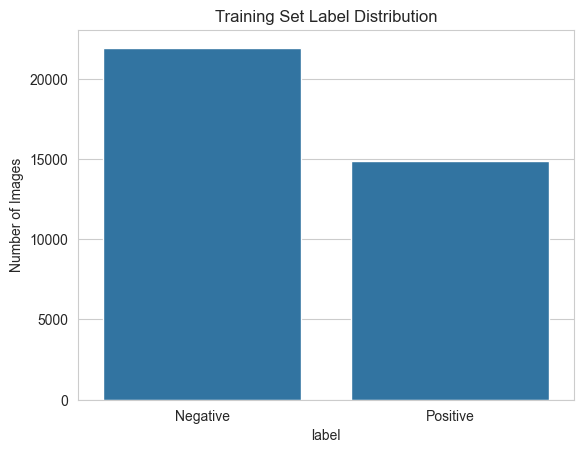

In [11]:
label_counts = train_meta['label'].value_counts()

plt.figure()
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks([0,1], ['Negative', 'Positive'])
plt.ylabel('Number of Images')
plt.title('Training Set Label Distribution')
plt.show()

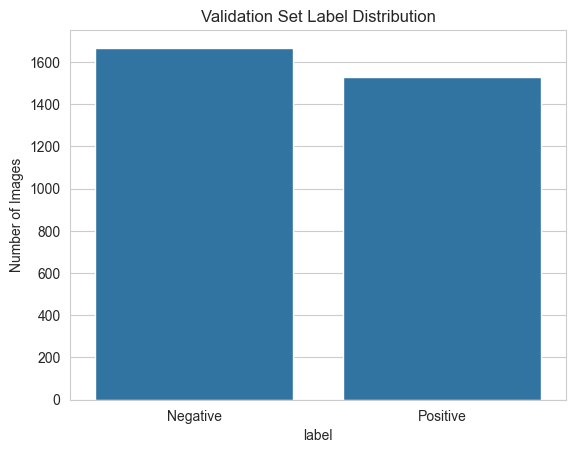

In [12]:
label_counts = valid_meta['label'].value_counts()

plt.figure()
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks([0,1], ['Negative', 'Positive'])
plt.ylabel('Number of Images')
plt.title('Validation Set Label Distribution')
plt.show()

The dataset is imbalanced, with fewer fracture-positive images. This motivates
the use of appropriate evaluation metrics and threshold-based decision logic.

With standard binary cross-entropy:
  - Each sample contributes equally to loss
  - Since negatives dominate, gradients are dominated by negatives
  - The model learns "It's safer to predict no fracture" - which is unnacceptable in medicine as it leads to:
    - High specificity
    - Low sensitivity 

## Body-part distribution

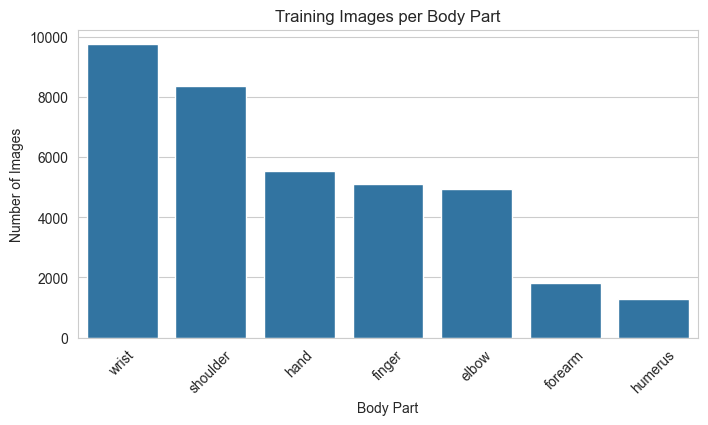

In [5]:
plt.figure(figsize=(8,4))
sns.countplot(
  data=train_meta,
  x='body_part',
  order=train_meta['body_part'].value_counts().index
)
plt.title('Training Images per Body Part')
plt.xticks(rotation=45)
plt.ylabel('Number of Images')
plt.xlabel('Body Part')
plt.show()

### Label distribution per body part

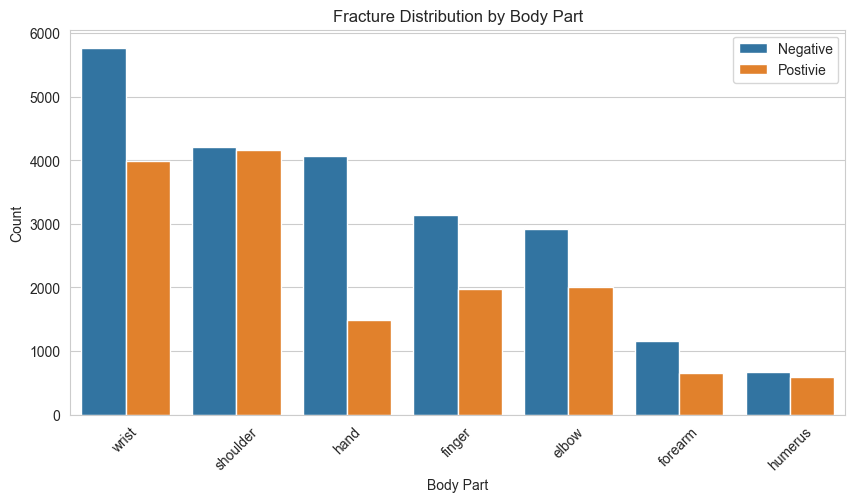

In [6]:
plt.figure(figsize=(10,5))
sns.countplot(
  data=train_meta,
  x='body_part',
  hue='label',
  order=train_meta['body_part'].value_counts().index
)
plt.legend(['Negative', 'Postivie'])
plt.title('Fracture Distribution by Body Part')
plt.xticks(rotation=45)
plt.xlabel('Body Part')
plt.ylabel('Count')
plt.show()

Fracture prevalence varies significantly by anatomical region, suggesting that
model confidence and interpretability may differ across body parts.


## Patient contribution analysis

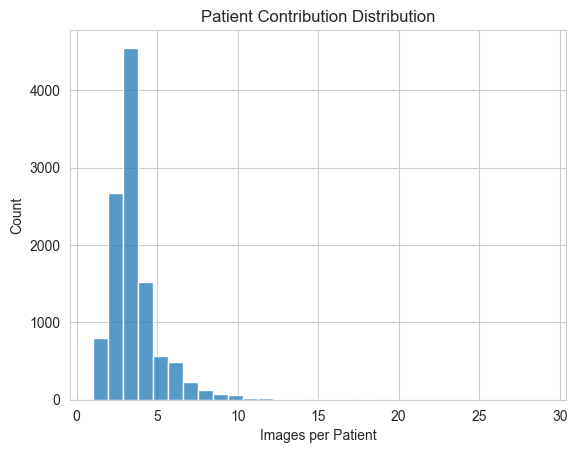

In [7]:
patient_image_counts = train_meta['patient_id'].value_counts()

plt.figure()
sns.histplot(patient_image_counts, bins=30)
plt.xlabel('Images per Patient')
plt.title('Patient Contribution Distribution')
plt.show()

Sanity Check

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..0.5484969].


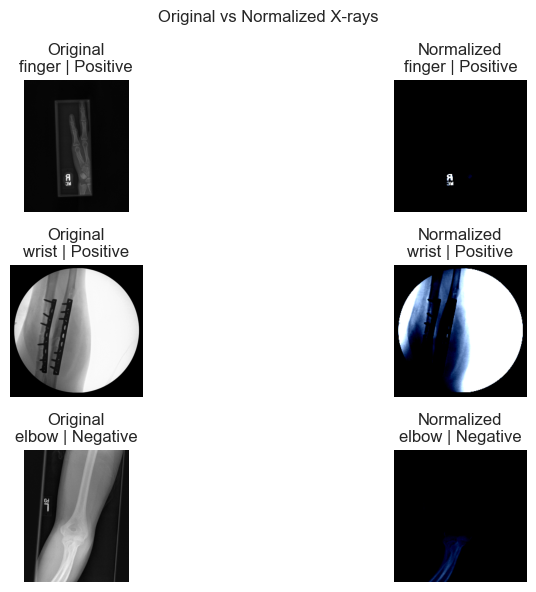

In [8]:
# Randomly sample indices
indices = np.random.choice(len(train_dataset), 3, replace=False)

plt.figure(figsize=(10, 6))

for i, idx in enumerate(indices):
    row = train_dataset.df.iloc[idx]
    n_img, label = train_dataset[idx]
    # Load original image
    img = Image.open(row["abs_path"]).convert("L")
    img_np = np.array(img)


    # Plot original
    plt.subplot(len(indices), 2, 2*i + 1)
    plt.imshow(img_np, cmap='gray')
    plt.title(f"Original\n{row['body_part']} | "
              f"{'Positive' if row['label'] == 1 else 'Negative'}")
    plt.axis("off")

    # Plot contrast-enhanced
    plt.subplot(len(indices), 2, 2*i + 2)
    plt.imshow(n_img.permute(1,2,0))
    plt.title(f"Normalized\n{row['body_part']} | "
              f"{'Positive' if row['label'] == 1 else 'Negative'}")
    plt.axis("off")

plt.suptitle("Original vs Normalized X-rays")
plt.tight_layout()
plt.show()


Pixel Intensity Distribution

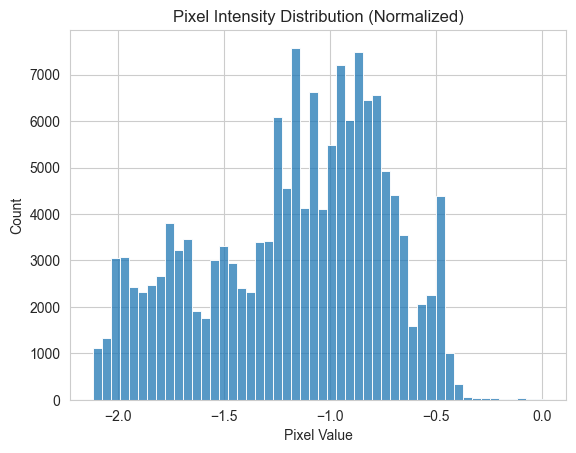

In [9]:
img, _ = train_dataset[0]
pixels = img.numpy().flatten()

plt.figure()
sns.histplot(pixels, bins=50)
plt.title("Pixel Intensity Distribution (Normalized)")
plt.xlabel("Pixel Value")
plt.show()


Pixel intensities in medical images are naturally non-Gaussian due to anatomical structure. Deep learning models don’t require Gaussian inputs; normalization is applied to stabilize optimization, not to enforce a bell-curve distribution.

### Key Observations

- The dataset exhibits class imbalance, with fewer fracture-positive images.
- Anatomical regions are unevenly represented, and fracture prevalence varies by body part.
- Fractures are often localized, motivating the use of Grad-CAM for interpretability.
- Taken together, these observations motivate a modeling approach that combines a CNN backbone for fracture classification with post-hoc localization via Grad-CAM. Fractures are spatially localized and class imbalance can encourage overconfident predictions, localization confidence is used as an additional criterion. When a predicted fracture lacks a clear, anatomically plausible activation region, the model returns an inconclusive result rather than a forced classification.
